<a href="https://colab.research.google.com/github/TaiseiYamana/Dataset-of-dog-for-pose-estimation-/blob/master/openpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# オリジナルのOpen Pose のインポート
# google drive をマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/'My Drive'
%ls

/content/drive/My Drive
 1e2.csv                  humanpafs.png   left.jpg     utils/
 1e5.csv                  img1.png        PAFs/        weights/
'Colab Notebooks'/        img2.png        result/      学習結果/
'confidence maps'/        img3.png        result.jpg   画像/
 data/                    img4.png        right.jpg
 hit-1407826_640.jpg      join.jpg        scale.png
 humanconfidencemap.jpg   kisokuka.png    tbX/


# 必要なパッケージのimport

In [ ]:
# 必要なパッケージのimport
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

# 画像、マスク画像、アノテーションデータへのファイルパスリストを作成
出力されるリスト  
    train_img_list 学習用画像のデータパス  
    train_mask_list 学習用マスク画像のデータパス  
    val_img_list 検証用画像のデータパス  
    val_mask_list 検証用マスク画像のデータパス  
    train_meta_list 学習用アノテーションデータ  
    val_meta_list 検証用アノテーションデータ  

In [ ]:
def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータ、マスクデータへのファイルパスリストを作成する。
    """
    # アノテーションのJSONファイルを読み込む
    train_path = osp.join(rootpath, 'dog_keypoints_train.json') #学習データのアノテーションのファイル名
    val_path = osp.join(rootpath, 'dog_keypoints_val.json') #検証データのアノテーションのファイル名
    with open(train_path) as train_data, open(val_path) as val_data:
        train_this = json.load(train_data)
        val_this =  json.load(val_data)
        train_image_json = train_this['images']
        val_image_json = val_this['images']    

        #アノテーションデータを格納
        train_meta_list = train_this['annotations']
        val_meta_list = val_this['annotations']

    # 画像ファイルパスを格納
    train_img_list = list()
    val_img_list = list()

    for idx in train_image_json:
        img_path = osp.join(rootpath,idx['path'][1:])
        train_img_list.append(img_path)
    
    for idx in val_image_json:
        img_path = osp.join(rootpath, idx['path'][1:])
        val_img_list.append(img_path)

    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []

    for idx in train_image_json:
        img_idx = idx['path'][-9:-4]
        anno_path = "./data/mask/train/mask_train_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_image_json:
        img_idx = idx['path'][-9:-4]
        anno_path = "./data/mask/val/mask_val_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


In [ ]:
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]

{'area': 417926,
 'bbox': [291, 252, 1202, 740],
 'category_id': 1,
 'color': '#34d61a',
 'id': 235,
 'image_id': 235,
 'isbbox': False,
 'iscrowd': False,
 'keypoints': [302,
  614,
  2,
  399,
  537,
  2,
  373,
  513,
  1,
  457,
  365,
  2,
  394,
  328,
  2,
  837,
  527,
  2,
  803,
  494,
  1,
  870,
  744,
  2,
  726,
  738,
  1,
  900,
  907,
  2,
  638,
  880,
  2,
  1263,
  535,
  2,
  1241,
  511,
  1,
  1186,
  863,
  2,
  1438,
  781,
  2,
  1129,
  924,
  2,
  1462,
  880,
  2],
 'metadata': {},
 'num_keypoints': 17,
 'segmentation': [[1173.5,
   416.3,
   1159,
   397.4,
   1127.7,
   379.2,
   1121.9,
   338.5,
   1147.3,
   289.8,
   1202.6,
   259.3,
   1292,
   252,
   1341.4,
   283.3,
   1367.4,
   352.8,
   1385.6,
   381.9,
   1381.9,
   387.7,
   1355,
   472.7,
   1357.2,
   507.6,
   1389.2,
   546.2,
   1430.2,
   579.3,
   1430.7,
   636.4,
   1405,
   652.5,
   1392.4,
   671.2,
   1394.5,
   701.7,
   1408.9,
   730.8,
   1432.5,
   754.5,
   1457.1,
   7

# マスクデータの働きを確認

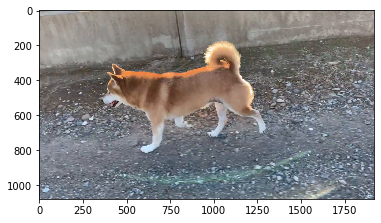

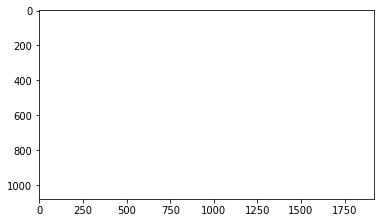

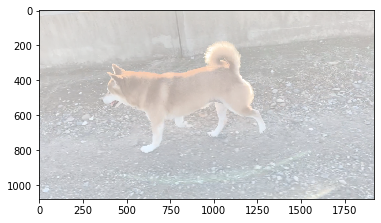

In [ ]:
index = 9

# 画像
img = cv2.imread(train_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(train_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 画像の前処理作成

In [ ]:
from utils.data_augumentation import Compose, get_anno, vchange,add_neck, aug_scale, aug_rotate, aug_flip,aug_croppad,remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    def __init__(self):
        self.data_transform = {
            'train':Compose ([
                get_anno(), # JSONからアノテーションを辞書に格納
                vchange(),
                add_neck(),  # アノテーションデータの順番を変更し、さらに首のアノテーションデータを追加
                aug_scale(),  # 拡大縮小
                #aug_rotate(),  # 回転
                aug_croppad(),  # 切り出し
                #aug_flip(),  # 左右反転
                remove_illegal_joint(),  # 画像からはみ出たアノテーションを除去
                #Normalize_Tensor()  # 色情報の標準化とテンソル化
                no_Normalize_Tensor()
            ]),
            'val':Compose([
                #省略
            ])
        }
    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](meta_data, img, mask_miss)

        return meta_data, img, mask_miss


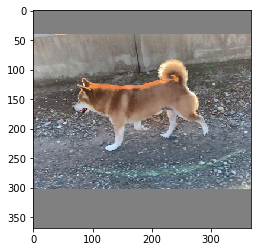

In [ ]:
# 動作確認
# 画像読み込み
index = 9
img = cv2.imread(train_img_list[index])
mask_miss = cv2.imread(train_mask_list[index])
meat_data = train_meta_list[index]

# 画像前処理
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

# 画像表示
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

In [ ]:
# 後処後の画像保存
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./image/img1_'+str(index)+'.png',img1)

True

In [ ]:
#入力画像の読み込み
img1 = cv2.imread(train_img_list[index])

#白い画像表示
img_white = np.ones((1080,1920, 3),np.uint8)*255
plt.plot(), plt.imshow(img_white)
plt.show()

#入力画像の表示
#img1 = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

img2 = cv2.imread('./img1.png')
#img2 = cv2.cvtColor(addimg, cv2.COLOR_BGR2RGB)

plt.imshow(img2)
plt.show()


large_img = img_white
small_img = img2

print(img2.shape)
print(1920-img2.shape[1])
print(1080-img2.shape[0])

In [ ]:
x_offset=1454
y_offset=818


large_img[y_offset:y_offset+small_img.shape[0], x_offset:x_offset+small_img.shape[1]] = small_img

plt.imshow(large_img)

blend_img = cv2.addWeighted(img1, 0.2, large_img, 0.85, 0)
plt.imshow(blend_img)
plt.show()

In [ ]:
#縮小の画像保存
cv2.imwrite('./scale.png',blend_img)


# 訓練データの正解情報として使うアノテーションデータの作成

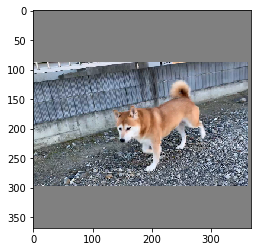

In [ ]:
from utils.dataloader import get_ground_truth

# 画像読み込み
index = 15
img = cv2.imread(train_img_list[index])
mask_miss = cv2.imread(train_mask_list[index])
meat_data = train_meta_list[index]

# 画像前処理
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPoseのアノテーションデータ生成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 画像表示
plt.imshow(img)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))


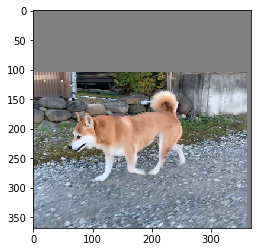

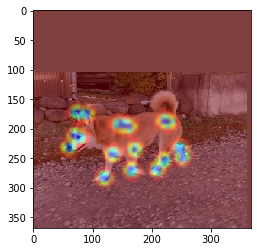

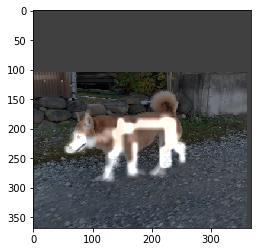

In [ ]:
from utils.dataloader import get_ground_truth

# 画像読み込み
index = 163
img = cv2.imread(train_img_list[index])
mask_miss = cv2.imread(train_mask_list[index])
meat_data = train_meta_list[index]

# 画像前処理
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPoseのアノテーションデータ生成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 画像表示
plt.imshow(img)
plt.show()

img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))


# 後処後の画像保存
img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('./image/img'+str(index)+'_1.png',img1)

heat_map = heatmaps[:, :, 18]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
 
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
save1 = blend_img
cv2.imwrite("./image/img"+str(index)+"_2.png",save1)
plt.imshow(blend_img)
plt.show()

#全ての　PAFを表示
links = [0,2,8,9,10,5,12,14,16,20,22,24,28,29,30,32,34,36]
for i in links:
    paf = pafs[:, :, i]
    paf = Image.fromarray(np.uint8((paf)*255))
    paf = np.asarray(paf.convert('RGB'))
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    if i == 0:
        blend_paf = paf
    else:
        blend_paf = cv2.addWeighted(blend_paf, 1.0, paf, 1.0, 0)

blend_img = cv2.addWeighted(img, 0.5, blend_paf, 0.7, 0)
save2 = blend_img
save2 = cv2.cvtColor(save2, cv2.COLOR_RGB2BGR)
cv2.imwrite("./image/img"+str(index)+"_3.png",save2)
plt.imshow(blend_img)
plt.show()

# heatmaps の確認

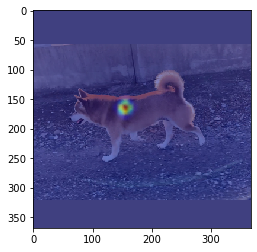

In [ ]:
# 左肘のheatmapを確認

heat_map = heatmaps[:, :, 1]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


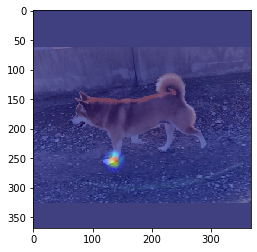

In [ ]:
# 左手のheatmapを確認

heat_map = heatmaps[:, :, 7]  # 7は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


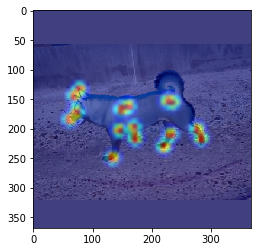

In [ ]:
# 全heatmapの表示

# 元画像
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

heat_map = heatmaps[:, :, 18]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する
heat_map = cv2.cvtColor(heat_map, cv2.COLOR_RGB2BGR)  
# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [ ]:
#　全heat mapsの保存
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  

for i in range(18):
  heat_map = heatmaps[:, :, i]
  heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
  heat_map = np.asarray(heat_map.convert('RGB'))
  heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する
  heat_map = cv2.cvtColor(heat_map, cv2.COLOR_RGB2BGR)  

# 合成して表示
  blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
  save = blend_img
  cv2.imwrite("./confidence maps/confidencemap_"+str(i)+".png",save)
  plt.imshow(blend_img)
  plt.show()


heat_map = heatmaps[:, :, 18]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
 
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
save = blend_img
cv2.imwrite("./confidence maps/confidencemap_"+str(18)+".png",save)
plt.imshow(blend_img)
plt.show()


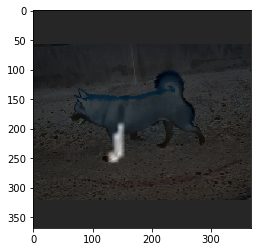

In [ ]:
# 左肘と左手首へのPAFを確認
paf = pafs[:, :, 24]  # 24は左肘と左手首をつなぐxベクトルのPAF

paf = Image.fromarray(np.uint8((paf)*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 合成して表示
blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()

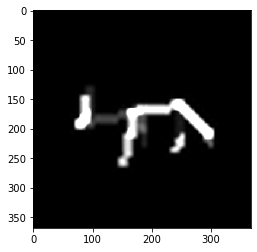

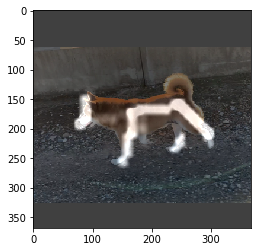

In [ ]:
#全ての　PAFを表示
links = [0,2,8,9,10,5,12,14,16,20,22,24,28,29,30,32,34,36]
for i in links:
    paf = pafs[:, :, i]
    paf = Image.fromarray(np.uint8((paf)*255))
    paf = np.asarray(paf.convert('RGB'))
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    if i == 0:
        blend_paf = paf
    else:
        blend_paf = cv2.addWeighted(blend_paf, 1.0, paf, 1.0, 0)

plt.imshow(blend_paf)
plt.show()

blend_img = cv2.addWeighted(img, 0.5, blend_paf, 0.7, 0)
plt.imshow(blend_img)
plt.show()

0


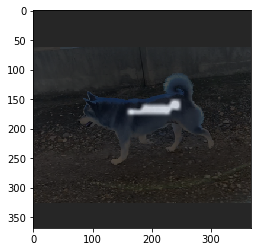

2


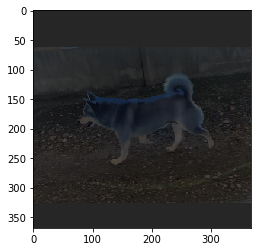

5


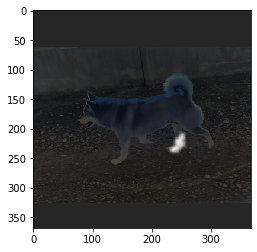

6


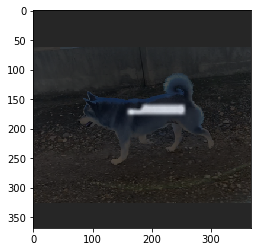

8


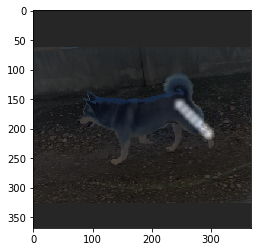

10


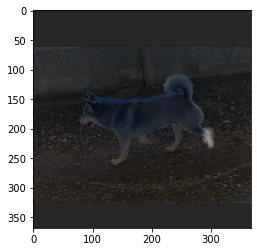

12


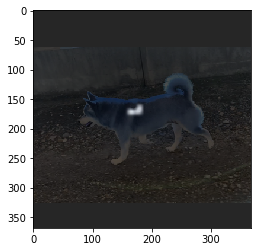

14


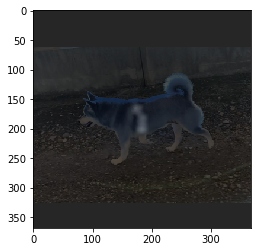

15


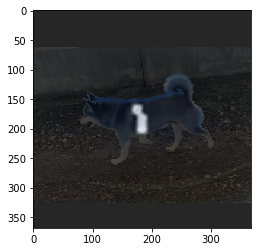

16


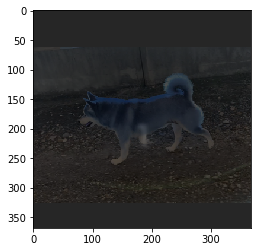

21


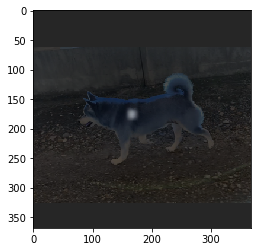

23


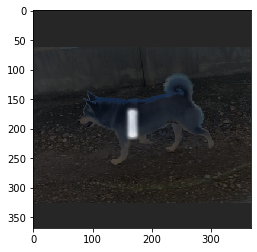

25


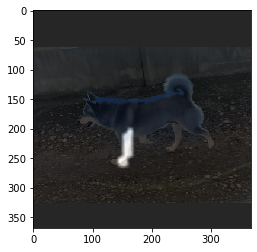

29


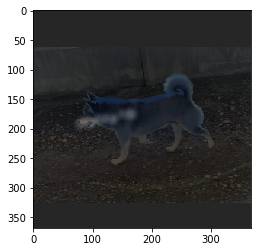

30


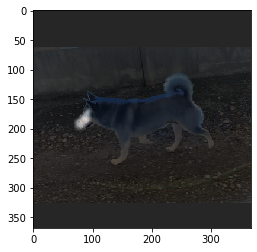

32


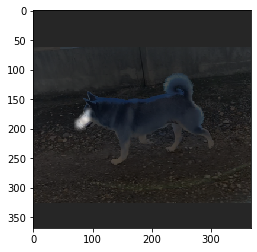

34


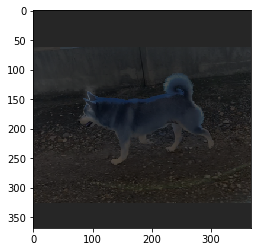

36


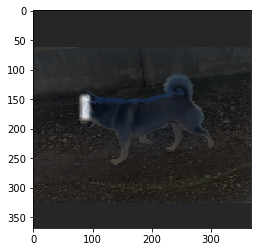

In [ ]:
#　全PAFsの保存

#img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

links = [0,2,5,6,8,10,12,14,15,16,21,23,25,29,30,32,34,36]
for i in links:
    paf = pafs[:, :, i]
    paf = Image.fromarray(np.uint8((paf)*255))
    paf = np.asarray(paf.convert('RGB'))
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    blend_img = cv2.addWeighted(img, 0.3, paf, 0.7, 0)

    save = blend_img
    cv2.imwrite("./PAFs/paf_"+str(i)+".png",save)
    print(i)
    plt.imshow(blend_img)
    plt.show()

In [ ]:
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# 学習

In [ ]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
from utils.dataloader import make_datapath_list, DataTransform, COCOkeypointsDataset

# MS COCOのファイルパスリスト作成
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

# Dataset作成
train_dataset = COCOkeypointsDataset(train_img_list, train_mask_list, train_meta_list, phase="train", transform=DataTransform())

val_dataset = COCOkeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# DataLoader作成
batch_size = 10

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [ ]:
from utils.openpose_net import OpenPoseNet
net = OpenPoseNet()


In [ ]:
# 損失関数の設定
class OpenPoseLoss(nn.Module):
    """OpenPoseの損失関数のクラスです。"""

    def __init__(self):
        super(OpenPoseLoss, self).__init__()

    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        """
        損失関数の計算。

        Parameters
        ----------
        saved_for_loss : OpenPoseNetの出力(リスト)

        heatmap_target : [num_batch, 19, 46, 46]
            正解の部位のアノテーション情報

        heatmap_mask : [num_batch, 19, 46, 46]
            heatmap画像のmask

        paf_target : [num_batch, 38, 46, 46]
            正解のPAFのアノテーション情報

        paf_mask : [num_batch, 38, 46, 46]
            PAF画像のmask

        Returns
        -------
        loss : テンソル
            損失の値
        """

        total_loss = 0
        # ステージごとに計算します
        for j in range(6):

            # PAFsとheatmapsにおいて、マスクされている部分（paf_mask=0など）は無視させる
            # PAFs
            pred1 = saved_for_loss[2 * j] * paf_mask
            gt1 = paf_target.float() * paf_mask

            # heatmaps
            pred2 = saved_for_loss[2 * j + 1] * heat_mask
            gt2 = heatmap_target.float()*heat_mask

            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')

        return total_loss


criterion = OpenPoseLoss()

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-2,
                      momentum=0.9,
                      weight_decay=0.0001)

In [ ]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                optimizer.zero_grad()
                print('（train）')

            # 今回は検証はスキップ
            else:
                continue
                # net.eval()   # モデルを検証モードに
                # print('-------------')
                # print('（val）')

            # データローダーからminibatchずつ取り出すループ
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # (out6_1, out6_2)は使わないので _ で代替
                    _, saved_for_loss = net(imges)

                    loss = criterion(saved_for_loss, heatmap_target,
                                     heat_mask, paf_target, paf_mask)
                    del saved_for_loss
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    # else:
                        #epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, 0))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/openpose_net_' +
               str(epoch+1) + '.pth')


In [ ]:
num_epochs = 20
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/20
-------------
（train）
-------------
epoch 1 || Epoch_TRAIN_Loss:0.0045 ||Epoch_VAL_Loss:0.0000
timer:  31.2920 sec.
-------------
Epoch 2/20
-------------
（train）
イテレーション 10 || Loss: 0.0042 || 10iter: 13.7470 sec.
-------------
epoch 2 || Epoch_TRAIN_Loss:0.0045 ||Epoch_VAL_Loss:0.0000
timer:  31.9058 sec.
-------------
Epoch 3/20
-------------
（train）
イテレーション 20 || Loss: 0.0042 || 10iter: 28.2128 sec.
-------------
epoch 3 || Epoch_TRAIN_Loss:0.0045 ||Epoch_VAL_Loss:0.0000
timer:  31.5548 sec.
-------------
Epoch 4/20
-------------
（train）
-------------
epoch 4 || Epoch_TRAIN_Loss:0.0045 ||Epoch_VAL_Loss:0.0000
timer:  31.5323 sec.
-------------
Epoch 5/20
-------------
（train）
イテレーション 30 || Loss: 0.0042 || 10iter: 9.3594 sec.
-------------
epoch 5 || Epoch_TRAIN_Loss:0.0045 ||Epoch_VAL_Loss:0.0000
timer:  31.7398 sec.
-------------
Epoch 6/20
-------------
（train）
イテレーション 40 || Loss: 0.0042 || 10iter: 23.1848 sec.
-------------
epoch 6 || Epoch

In [ ]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [ ]:
from utils.openpose_net import OpenPoseNet

# 学習済みモデルと本章のモデルでネットワークの層の名前が違うので、対応させてロードする
# モデルの定義
net = OpenPoseNet()

# 学習済みパラメータをロードする
net_weights = torch.load(
    './weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# ロードした内容を、本書で構築したモデルの
# パラメータ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]
                 ] = net_weights[list(keys)[i]]

# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


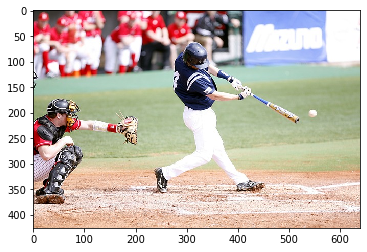

In [ ]:
# テストの画像を読み込み、前処理します

test_image = './hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,Rの順番

# BGRをRGBにして表示
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 画像の前処理
img = img.astype(np.float32) / 255.

# 色情報の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （高さ、幅、色）→（色、高さ、幅）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をTensorに
img = torch.from_numpy(img)

# ミニバッチ化：torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [ ]:
# OpenPoseでheatmapsとPAFsを求めます
net.eval()
predicted_outputs, _ = net(x)

# 画像をテンソルからNumPyに変化し、サイズを戻します
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

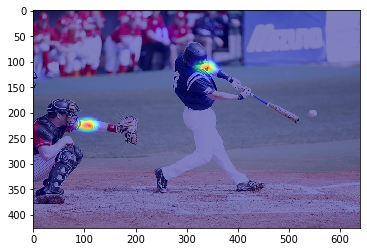

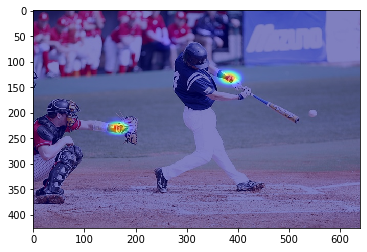

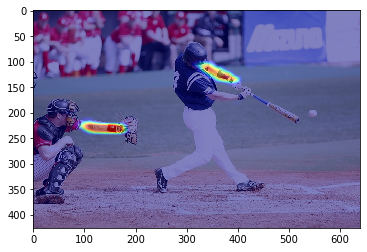

In [ ]:
# 左肘と左手首のheatmap、そして左肘と左手首をつなぐPAFのxベクトルを可視化する
# 左肘
heat_map = heatmaps[:, :, 6]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 左手首
heat_map = heatmaps[:, :, 7]  # 7は左手首
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()


# 左肘と左手首をつなぐPAFのxベクトル
paf = pafs[:, :, 24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

In [ ]:
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

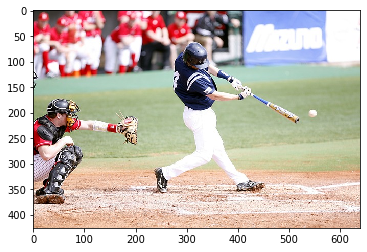

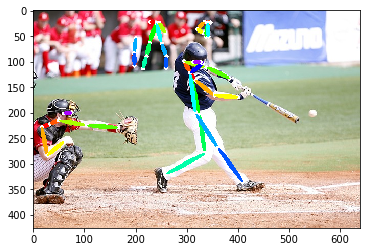

In [ ]:
# 結果を描画
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()
